[28 批量归一化](https://www.bilibili.com/video/BV1X44y1r77r?spm_id_from=333.999.0.0)

- 之前提及的神经网络存在一个问题
    - 神经网络每层的梯度是不尽相同的，梯度变化一般是底层较大，顶层较小
    - 梯度变化的不一致会导致反向传播的时候，顶层变化速度较慢
    - 底层收敛速度虽然比较快，但是顶层每次发生变化，底层参数都需要重新训练
    - 很显然，我们希望有一种办法能够加快顶层的收敛速度

- <img src="picture\屏幕截图 2022-05-15 230011.png"></a>
    - 批量归一化，就是使得一个mini_batch的参数符合一个有规律的分部
    - 这里才方差和分部相当于新的训练参数

- <img src="picture\屏幕截图 2022-05-15 230633.png"></a>
    - 重点关注作用在哪就行

- <img src="picture\屏幕截图 2022-05-15 233801.png"></a>
    - 后面研究和最初设想不一致，后期研究更倾向于通过随机方差和均值引入了噪音数据
    - 总体而言，批量归一化层可以加速收敛速度，但一般不改变模型精度
    - 附注：卷积神经网络一般不使用像素级别的dropout层，因为相邻像素之间是存在关联的

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
def batch_norm(X,gamma,beta,moving_mean,moving_var,eps,momentum):
    """
    Args:
        拉伸gamma 和偏移beta, 这两个参数将在训练过程中更新
        moving_mean,moving_var: 整个数据集上的均值和方差
        eps :主要用于避免出现0梯度
        momentum (_type_): 更新mean和var用
    """
    if not torch.is_grad_enabled():
        # 通过is_grad_enabled来判断当前模式是训练模式还是预测模式
        X_hat = (X - moving_mean)/torch.sqrt(moving_var+eps)
    
    else:
        # 这里限制只处理低阶数据
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # 使用全连接层的情况，计算特征维上的均值和方差
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # 使用二维卷积层的情况，计算通道维上（axis=1）的均值和方差。
            # 这里我们需要保持X的形状以便后面可以做广播运算
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # 训练模式下，用当前的均值和方差做标准化
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # 更新移动平均的均值和方差
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta  # 缩放和移位
    return Y, moving_mean.data, moving_var.data

# momentum概念：动量，相当于

In [3]:
# 创建batch_norm层
class BatchNorm(nn.Module):
    # `num_features`：完全连接层的输出数量或卷积层的输出通道数。
    # `num_dims`：2表⽰完全连接层，4表⽰卷积层  
    def __init__(self,num_features,num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1,num_features)
        else:
            shape = (1,num_features,1,1)
        # 参与求梯度和迭代的拉伸和偏移参数，分别初始化成1和0
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # ⾮模型参数的变量初始化为0和1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)
    
    def forward(self,X):
        # 如果`X` 不在内存上，将`moving_mean` 和`moving_var`
        # 复制到`X` 所在显存上
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # 保存更新过的`moving_mean` 和`moving_var`
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.9)
        return Y


In [4]:
# 使⽤批量归⼀化层的LeNet
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), 
    BatchNorm(6, num_dims=4), 
    nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5),
    BatchNorm(16, num_dims=4), 
    nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2, stride=2), 
    nn.Flatten(),
    nn.Linear(16*4*4, 120), 
    BatchNorm(120, num_dims=2), 
    nn.Sigmoid(),
    nn.Linear(120, 84), 
    BatchNorm(84, num_dims=2), 
    nn.Sigmoid(),
    nn.Linear(84, 10),
    )

In [5]:
X = torch.randn(size=(1, 1, 28, 28))
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__,'output shape:\t',X.shape)

Conv2d output shape:	 torch.Size([1, 6, 24, 24])
BatchNorm output shape:	 torch.Size([1, 6, 24, 24])
Sigmoid output shape:	 torch.Size([1, 6, 24, 24])
MaxPool2d output shape:	 torch.Size([1, 6, 12, 12])
Conv2d output shape:	 torch.Size([1, 16, 8, 8])
BatchNorm output shape:	 torch.Size([1, 16, 8, 8])
Sigmoid output shape:	 torch.Size([1, 16, 8, 8])
MaxPool2d output shape:	 torch.Size([1, 16, 4, 4])
Flatten output shape:	 torch.Size([1, 256])
Linear output shape:	 torch.Size([1, 120])
BatchNorm output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
BatchNorm output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


loss 0.252, train acc 0.908, test acc 0.876
51433.1 examples/sec on cuda:0


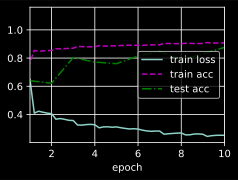

In [6]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())
# 可以看出，收敛明显变好了

In [7]:
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

(tensor([1.4510, 1.0529, 2.3422, 2.2275, 2.0293, 2.5792], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>),
 tensor([-1.6178,  0.2934,  0.8745, -0.3580,  0.0379, -2.6876], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>))

In [8]:
# 调包侠特供版
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), 
    nn.BatchNorm2d(6,momentum=0.9), 
    nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), 
    nn.BatchNorm2d(16), 
    nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2, stride=2), 
    nn.Flatten(),
    nn.Linear(256, 120), 
    nn.BatchNorm1d(120,momentum=0.9), 
    nn.Sigmoid(),
    nn.Linear(120, 84), 
    nn.BatchNorm1d(84,momentum=0.9), 
    nn.Sigmoid(),
    nn.Linear(84, 10))

loss 0.248, train acc 0.909, test acc 0.881
78788.6 examples/sec on cuda:0


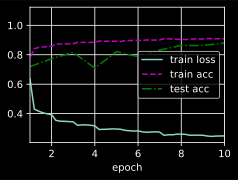

In [9]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())